In [1]:
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/BLA_LFP_data/LFP_BLA_gamma.mat'  # True In Vivo Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'  # Pink Noise/Background
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'  # Buried Gamma in BG
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/Generated/pn_multisine_gamma.npz'  # Generated Sine in PN
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine_syn_noise.mat'  # Synthetic Feng 1000 cell model Data
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'  # Feng Raw 1000 cell model Data

In [2]:
from lfp_prediction.data_gathering import MatlabCollector, NumpyCollector, TextCollector

frequency_band = (55, 85)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
    del data
    del labels
dc = MatlabCollector(INVIVO_RAW_PATH)
dc.get_data()
data, labels = dc.filter_data(filter_type='non-causal',
                              freq_band=frequency_band,
                              filter_rate=100)

76792
(146108, 1, 300)
(146108, 1, 300)


In [21]:
from sklearn.decomposition import PCA
import numpy as np
np.set_printoptions(precision=3, suppress=True)

pca = PCA()

pca.fit(np.squeeze(data).T)
print(pca.components_.shape)
print(pca.explained_variance_ratio_ * 100)

(300, 146108)
[17.885 14.16  11.099  9.989  8.691  7.531  5.952  4.468  3.135  2.318
  1.783  1.444  1.159  0.942  0.775  0.645  0.538  0.465  0.396  0.347
  0.309  0.276  0.248  0.226  0.225  0.223  0.214  0.212  0.201  0.198
  0.193  0.182  0.178  0.173  0.166  0.161  0.155  0.152  0.144  0.143
  0.141  0.134  0.133  0.131  0.13   0.128  0.114  0.102  0.09   0.079
  0.07   0.061  0.055  0.048  0.043  0.038  0.035  0.031  0.028  0.025
  0.023  0.021  0.019  0.018  0.016  0.015  0.014  0.013  0.013  0.012
  0.011  0.011  0.01   0.009  0.009  0.009  0.008  0.008  0.008  0.007
  0.007  0.007  0.007  0.006  0.006  0.006  0.006  0.006  0.006  0.005
  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.004
  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.004
  0.004  0.004  0.004  0.004  0.004  0.003  0.003  0.003  0.003  0.003
  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003
  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003

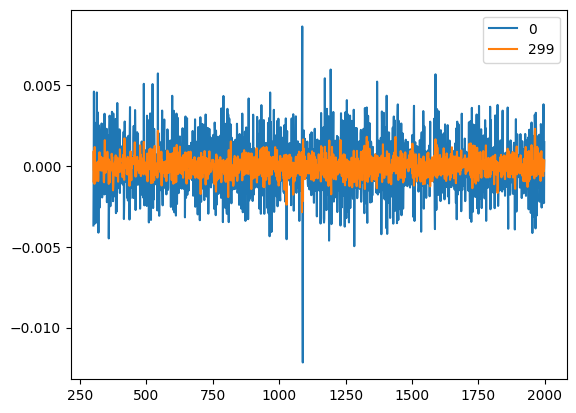

In [37]:
import matplotlib.pyplot as plt

t = np.arange(pca.components_.shape[1])

start_idx = 300
end_idx = 2000

components = [0] + [i for i in range(299, 300)]

labels = list(map(str, components))

line_object = plt.plot(t[start_idx:end_idx], pca.components_[components, start_idx:end_idx].T)
plt.legend(line_object, labels)
plt.show()